SIN-393 - Introdução à Visão Computacional (2022-2)

# Aula 09 - Detecção e reconhecimento de objetos (Parte 1)

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importando as bibliotecas
---

In [1]:
import os
from distutils.version import LooseVersion
from packaging import version

import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.models import detection

%matplotlib notebook

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.12.1
0.13.1


## Verificando o acesso à GPU
---


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


## Configurando o dataset
---

* COCO dataset

In [4]:
ds_path = '/home/joao/Datasets/coco-2017-dataset/coco/'

images_path = os.path.join(ds_path, 'images', 'train2017')
image_name = os.listdir(images_path)[2]

print(images_path)
print(image_name)

/home/joao/Datasets/coco-2017-dataset/coco/images/train2017
000000220511.jpg


## Some hiperparameters

In [5]:
CONFIDENCE = 0.5

## Building the model
---

In [6]:
### if LooseVersion(torchvision.__version__) < LooseVersion('0.3'):
if version.parse(torchvision.__version__) < version.parse('0.13'):
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, pretrained_backbone=True)
else:
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

# Envia o modelo paa a GPU
model.to(DEVICE)

# Seta o modelo para modo de avaliação
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
# load the image from disk
### image = cv2.imread(args["image"])
image = cv2.imread(os.path.join(images_path, image_name))
### orig = image.copy()

# convert the image from BGR to RGB channel ordering 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# copy the image to visualize the results
orig = image.copy()

# change the image from channels last to channels first ordering
image = image.transpose((2, 0, 1))

# add the batch dimension
image = np.expand_dims(image, axis=0)

# scale the raw pixel intensities to the range [0, 1],
image = image / 255.0

# convert the image to a floating point tensor
image = torch.FloatTensor(image)

# send the input to the device 
image = image.to(DEVICE)

# pass the it through the network to get the detections and predictions
detections = model(image)[0]

[INFO] bicycle: 99.86%
[INFO] bicycle: 99.75%
[INFO] baseballbat: 99.40%
[INFO] bicycle: 99.29%
[INFO] bicycle: 99.25%
[INFO] bicycle: 99.23%
[INFO] baseballbat: 99.03%
[INFO] bicycle: 98.91%
[INFO] bicycle: 95.31%
[INFO] bicycle: 95.04%
[INFO] bicycle: 93.35%
[INFO] bicycle: 91.41%
[INFO] surfboard: 89.29%
[INFO] bicycle: 85.34%
[INFO] bicycle: 63.15%
[INFO] kite: 56.78%
[INFO] bicycle: 54.57%
[INFO] cat: 51.25%
[INFO] bicycle: 50.43%


<IPython.core.display.Javascript object>


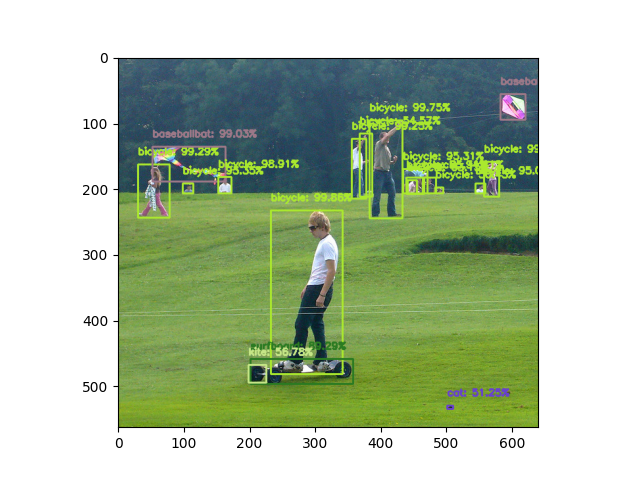

In [8]:
CLASSES = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'trafficlight', 'firehydrant', 'streetsign', 'stopsign', 'parkingmeter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eyeglasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sportsball', 'kite', 'baseballbat', 'baseballglove', 'skateboard', 'surfboard', 'tennisracket', 'bottle', 'plate', 'wineglass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'mirror', 'diningtable', 'window', 'desk', 'toilet', 'door', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cellphone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddybear', 'hairdrier', 'toothbrush', 'hairbrush']
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# loop over the detections
for i in range(0, len(detections["boxes"])):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections["scores"][i]
    # print(confidence)
    
    # filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > CONFIDENCE:
        # extract the index of the class label from the detections,
        # then compute the (x, y)-coordinates of the bounding box for the object
        idx = int(detections["labels"][i])
        box = detections["boxes"][i].detach().cpu().numpy()
        (startX, startY, endX, endY) = box.astype("int")
        
        # display the prediction to our terminal
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[INFO] {}".format(label))
        
        # draw the bounding box and label on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), COLORS[idx], 2)
        
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
        
# show the output image
plt.imshow(orig)

## Bibliography
---

* Adrian Rosebrock. ***PyTorch object detection with pre-trained networks.***
    * https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

* COCO dataset
    * https://blog.roboflow.com/coco-dataset/

* Script para baixar o COCO dataset.
    * https://github.com/ultralytics/yolov5/blob/master/data/scripts/get_coco.sh